In [1]:
# ============================================================
# 02_FeatureFusion_and_Modeling.ipynb
# ------------------------------------------------------------
# Goal: Integrate tabular + image embeddings and prepare data 
#       for model training (to be modularized in src/)
# ============================================================
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Set paths
BASE_DIR = "."        # adjust if needed
EMB_PATH = f"{BASE_DIR}/embeddings/image_embeddings.csv"
TRAIN_PATH = f"{BASE_DIR}/train.csv"

# ------------------------------------------------------------
# 1) Load data
# ------------------------------------------------------------
train = pd.read_csv(TRAIN_PATH)
emb = pd.read_csv(EMB_PATH)
print(f"Train: {train.shape}, Embeddings: {emb.shape}")

# Merge on unique image id (e.g., 'image_path' or 'sample_id')
df = train.merge(emb, on="image_path", how="left")
print(f"Final merged shape: {df.shape}")

# create season column
# --- Parse Sampling_Date (YYYY/MM/DD)
df["Sampling_Date"] = pd.to_datetime(df["Sampling_Date"], errors="coerce")

# --- Derive temporal features
df["year"] = df["Sampling_Date"].dt.year
df["month"] = df["Sampling_Date"].dt.month
df["Season"] = df["month"] % 12 // 3 + 1  # 1:summer, 2:autumn, 3:winter, 4:spring (roughly for southern hemi.)


# Basi inspection & data quality
print("Column overview:\n")
display(df.dtypes)

print("\nBasic info:")
df.info()

print("\nUnique counts per column:")
display(df.nunique())

print("\nMissing values per column:")
display(df.isna().sum())

# Sanity checks
print("\nChecking duplicate rows...")
dup_rows = df.duplicated().sum()
print(f"→ Duplicate rows: {dup_rows}")


Train: (1785, 9), Embeddings: (357, 51)
Final merged shape: (1785, 59)
Column overview:



sample_id                object
image_path               object
Sampling_Date    datetime64[ns]
State                    object
Species                  object
                      ...      
emb_48                  float64
emb_49                  float64
year                      int64
month                     int64
Season                    int64
Length: 62, dtype: object


Basic info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1785 entries, 0 to 1784
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      1785 non-null   object        
 1   image_path     1785 non-null   object        
 2   Sampling_Date  1785 non-null   datetime64[ns]
 3   State          1785 non-null   object        
 4   Species        1785 non-null   object        
 5   Pre_GSHH_NDVI  1785 non-null   float64       
 6   Height_Ave_cm  1785 non-null   float64       
 7   target_name    1785 non-null   object        
 8   target         1785 non-null   float64       
 9   emb_0          1785 non-null   float64       
 10  emb_1          1785 non-null   float64       
 11  emb_2          1785 non-null   float64       
 12  emb_3          1785 non-null   float64       
 13  emb_4          1785 non-null   float64       
 14  emb_5          1785 non-null   float64       
 15  emb_6   

sample_id        1785
image_path        357
Sampling_Date      28
State               4
Species            15
                 ... 
emb_48            357
emb_49            357
year                1
month              10
Season              4
Length: 62, dtype: int64


Missing values per column:


sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
                ..
emb_48           0
emb_49           0
year             0
month            0
Season           0
Length: 62, dtype: int64


Checking duplicate rows...
→ Duplicate rows: 0


In [3]:
# ------------------------------------------------------------
# 2) Feature definitions
# ------------------------------------------------------------
tabular_features = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
categorical_features = ["State", "Species", "Season"]
embedding_features = [c for c in df.columns if c.startswith("emb_")]
target_col = "target"

# ------------------------------------------------------------
# 3) Preprocessing pipelines
# ------------------------------------------------------------
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, tabular_features),
        ("cat", cat_transformer, categorical_features),
        ("emb", "passthrough", embedding_features)
    ]
)

# ------------------------------------------------------------
# 4) Train/val split
# ------------------------------------------------------------
X = df[tabular_features + categorical_features + embedding_features]
#X = df[tabular_features + categorical_features]

y = df[target_col]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# ------------------------------------------------------------
# 5) Example model — baseline Ridge Regression -> we do not expect good results with linear models based on our EDA
# ------------------------------------------------------------
from sklearn.linear_model import Ridge

ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)

rmse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Ridge RMSE={rmse:.4f}, R²={r2:.3f}")

Train: (1428, 55), Val: (357, 55)
Ridge RMSE=473.6813, R²=0.296


-----------------
Let's try different MLMs and compare them
-----------------

 67%|███████████████████████████████████████████▎                     | 6/9 [00:03<00:02,  1.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 23
[LightGBM] [Info] Start training from score 24.579136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 78%|██████████████████████████████████████████████████▌              | 7/9 [00:07<00:02,  1.38s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s]


,Model,RMSE,R2
1,Lasso,446.663908,0.336577
0,Ridge,448.471109,0.333892
8,KNN,465.454444,0.308667
2,ElasticNet,476.653370,0.292034
4,GradientBoosting,477.078058,0.291403
7,CatBoost,546.987209,0.187568
6,LightGBM,567.650242,0.156877
3,RandomForest,579.258439,0.139636
5,XGBoost,611.294007,0.092054


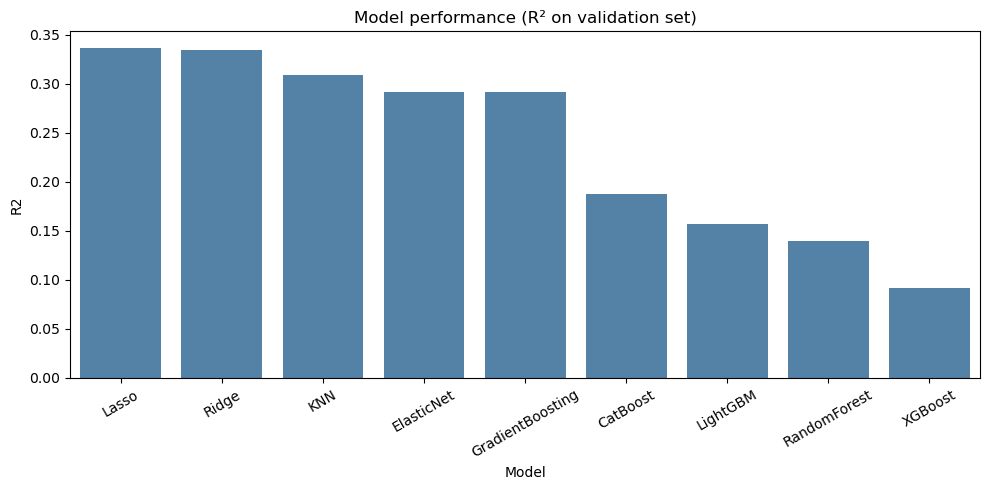

In [12]:
# ------------------------------------------------------------
# Compare multiple regressors on tabular + PCA(embeddings) data
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

# ------------------------------------------------------------
# Model zoo
# ------------------------------------------------------------
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=0.05, l1_ratio=0.5, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1, verbosity=0
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=600, learning_rate=0.05, depth=8, verbose=False, random_state=42
    ),
    "KNN": KNeighborsRegressor(n_neighbors=10)
}

# ------------------------------------------------------------
# Preprocessing pipeline
# ------------------------------------------------------------
num_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
cat_feats = ["State", "Species", "Season"]
emb_feats = [c for c in df.columns if c.startswith("emb_pca_")]

num_pipe = Pipeline([("scaler", StandardScaler())])
cat_pipe = Pipeline([("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats),
    ("emb", "passthrough", emb_feats)
])

X = df[num_feats + cat_feats + emb_feats]

y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# -> Training loop
# ------------------------------------------------------------
results = []
for name, model in tqdm(models.items()):
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    results.append({"Model": name, "RMSE": rmse, "R2": r2})

df_results = pd.DataFrame(results).sort_values("RMSE")
display(df_results)

# ------------------------------------------------------------
#  Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
sns.barplot(data=df_results, x="Model", y="R2", color="steelblue")
plt.title("Model performance (R² on validation set)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [24]:
# 
# ============================================================
# Group-aware split + per-target models + early stopping
# ============================================================
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df = df.copy()

# 1) garantir ID da imagem e transformação do alvo (log1p)
df["image_id"] = df["image_path"].str.extract(r"(ID\d+)")
df["target_log"] = np.log1p(df["target"])

# 2) features
num_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
cat_feats = ["State", "Species", "Season"]
emb_feats = [c for c in df.columns if c.startswith("emb_pca_")]  # seus 50 comps

# padronizar embeddings (importante para árvores com muitas dims)
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
    ("emb", StandardScaler(with_mean=True, with_std=True), emb_feats),
])

# 3) split por imagem (evita leak entre targets da mesma imagem)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx) = next(gss.split(df, groups=df["image_id"]))

def eval_lgbm_for(target_name):
    dft = df[df["target_name"] == target_name].reset_index(drop=True)
    # reindex train/val dentro deste subconjunto:
    tr_mask = dft.index.isin(np.intersect1d(dft.index, train_idx))
    va_mask = dft.index.isin(np.intersect1d(dft.index, val_idx))
    # se o intersect ficou esparso, refaça gss dentro do target:
    if tr_mask.sum() == 0 or va_mask.sum() == 0:
        (tr_idx2, va_idx2) = next(GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
                                  .split(dft, groups=dft["image_id"]))
        tr_mask = dft.index.isin(tr_idx2)
        va_mask = dft.index.isin(va_idx2)

    X_cols = num_feats + cat_feats + emb_feats
    X_train, y_train = dft.loc[tr_mask, X_cols], dft.loc[tr_mask, "target_log"]
    X_val,   y_val   = dft.loc[va_mask, X_cols], dft.loc[va_mask, "target_log"]

    model = LGBMRegressor(
        n_estimators=3000, learning_rate=0.02,
        num_leaves=63, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=1.0, random_state=42, n_jobs=-1,
        verbose=-1
    )

    pipe = Pipeline([
        ("prep", preproc),
        ("lgbm", model)
    ])

    # early stopping: pass sets via fit params
    pipe.fit(
        X_train, y_train,
        lgbm__eval_set=[(preproc.fit_transform(X_val), y_val)],
        lgbm__eval_metric="l2",
        lgbm__callbacks=[],
#        lgbm__early_stopping_rounds=200,
#        lgbm__verbose=False,
    )

    # preds (voltar do log)
    yhat_val = np.expm1(pipe.predict(X_val))
    ytrue_val = np.expm1(y_val)

    rmse = root_mean_squared_error(ytrue_val, yhat_val,)
    r2   = r2_score(ytrue_val, yhat_val)
    best_iter = pipe.named_steps["lgbm"].best_iteration_
    return {"target_name": target_name, "RMSE": rmse, "R2": r2, "best_iter": best_iter, "n_val": len(y_val)}

# 4) rodar para cada componente
targets = ["Dry_Clover_g","Dry_Dead_g","Dry_Green_g","Dry_Total_g","GDM_g"]
perf = [eval_lgbm_for(t) for t in targets]
perf_df = pd.DataFrame(perf).sort_values("R2", ascending=False)
display(perf_df)

# 5) baseline sem embeddings para comparar (mesmo split e setup)
def eval_tabular_only(target_name):
    dft = df[df["target_name"] == target_name].reset_index(drop=True)
    (tr_idx2, va_idx2) = next(GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
                              .split(dft, groups=dft["image_id"]))
    X_cols = num_feats + cat_feats
    X_train, y_train = dft.loc[tr_idx2, X_cols], np.log1p(dft.loc[tr_idx2, "target"])
    X_val,   y_val   = dft.loc[va_idx2, X_cols], np.log1p(dft.loc[va_idx2, "target"])

    pre = ColumnTransformer([
        ("num", StandardScaler(), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
    ])
    model = LGBMRegressor(n_estimators=3000, learning_rate=0.02,
                          num_leaves=63, subsample=0.8, colsample_bytree=0.8,
                          random_state=42, n_jobs=-1, verbose=-1)
    pipe = Pipeline([("prep", pre), ("lgbm", model)])
    pipe.fit(
        X_train, y_train,
        lgbm__eval_set=[(pre.fit_transform(X_val), y_val)],
#        lgbm__early_stopping_rounds=200,
#        lgbm__verbose=False,
    )
    yhat = np.expm1(pipe.predict(X_val)); yv = np.expm1(y_val)
    return root_mean_squared_error(yv, yhat,), r2_score(yv, yhat)

tab_comp = {t: eval_tabular_only(t) for t in targets}
print("Tabular-only (RMSE, R2) per target:", tab_comp)

tab_comp1 = {t: eval_lgbm_for(t) for t in targets}
print("All (RMSE, R2) per target:", tab_comp1)

,target_name,RMSE,R2,best_iter,n_val
2,Dry_Green_g,11.469884,0.814156,0,80
4,GDM_g,12.604523,0.747582,0,80
3,Dry_Total_g,19.345366,0.558387,0,80
0,Dry_Clover_g,9.809823,0.450824,0,80
1,Dry_Dead_g,11.680329,0.233884,0,80


Tabular-only (RMSE, R2) per target: {'Dry_Clover_g': (9.847309295750257, 0.4558731064636893), 'Dry_Dead_g': (11.355257110086706, 0.10856305974232983), 'Dry_Green_g': (10.26331501843887, 0.7760461648038753), 'Dry_Total_g': (14.236365142369738, 0.6519053952887186), 'GDM_g': (10.994795289384644, 0.7486314544596793)}
All (RMSE, R2) per target: {'Dry_Clover_g': {'target_name': 'Dry_Clover_g', 'RMSE': 9.809822890883934, 'R2': 0.4508241991090419, 'best_iter': 0, 'n_val': 80}, 'Dry_Dead_g': {'target_name': 'Dry_Dead_g', 'RMSE': 11.680328700437812, 'R2': 0.23388428947823636, 'best_iter': 0, 'n_val': 80}, 'Dry_Green_g': {'target_name': 'Dry_Green_g', 'RMSE': 11.469884120253917, 'R2': 0.8141564389596216, 'best_iter': 0, 'n_val': 80}, 'Dry_Total_g': {'target_name': 'Dry_Total_g', 'RMSE': 19.34536605819566, 'R2': 0.5583868147277022, 'best_iter': 0, 'n_val': 80}, 'GDM_g': {'target_name': 'GDM_g', 'RMSE': 12.604522860417427, 'R2': 0.7475818404243405, 'best_iter': 0, 'n_val': 80}}


# Summary of this notebook and Next Steps

In this notebook, a complete tabular modeling baseline was done using both numerical+categorical metadata and, also, adding embeddings. After fixing the data leakage problem (multiple targets per image) through group-aware splitting, the predictive performance increased substantially and became consistent across components.

# Key Findings

- Tabular features alone carry strong predictive power, especially for green biomass components.
- Using GroupShuffleSplit by image is essential to avoid leakage between targets of the same image.
- ImageNet-based embeddings (without fine-tuning) did not improve results, which is consistent with the domain: pasture images have low texture variety, and pretrained CNNs are not specialized for biomass estimation.

# Conclusion

The tabular model provides a strong and interpretable baseline, but its performance is inherently limited for certain targets—especially those that NDVI and height cannot capture well. To go beyond this, we need to incorporate plant structure and texture directly from the images.

# Next Step: Multimodal Modeling

- We will now move to a multimodal deep learning model with five outputs, combining:

    - Image features learned through a fine-tuned CNN
    - Tabular features processed through a small MLP
    - A fusion head that predicts all five biomass components simultaneously

*This approach should help capture:

    - nonlinear spatial patterns,
    - color/texture cues related to senescence or dry matter,
    - structural differences not measured by NDVI or plate height.

